In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import nltk
import string
import json
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk import stem
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import re
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

### Data Preprocessing

In [2]:
df = pd.read_csv('tmdb_5000_movies.csv')

In [3]:
df.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


#### Parse json columns

In [4]:
df['genres'] = df['genres'].apply(json.loads)
df['genres'] = df['genres'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [5]:
df['keywords'] = df['keywords'].apply(json.loads)
df['keywords'] = df['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [6]:
df['production_companies'] = df['production_companies'].apply(json.loads)
df['production_companies'] = df['production_companies'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [7]:
df['production_countries'] = df['production_countries'].apply(json.loads)
df['production_countries'] = df['production_countries'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [8]:
df['spoken_languages'] = df['spoken_languages'].apply(json.loads)
df['spoken_languages'] = df['spoken_languages'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [9]:
df.head(n=2)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[Action, Adventure, Fantasy, Science Fiction]",http://www.avatarmovie.com/,19995,"[culture clash, future, space war, space colon...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[Ingenious Film Partners, Twentieth Century Fo...","[United States of America, United Kingdom]",2009-12-10,2787965087,162.0,"[English, Español]",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[Adventure, Fantasy, Action]",http://disney.go.com/disneypictures/pirates/,285,"[ocean, drug abuse, exotic island, east india ...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[Walt Disney Pictures, Jerry Bruckheimer Films...",[United States of America],2007-05-19,961000000,169.0,[English],Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500


In [10]:
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit_transform(df['genres'])

array([[1, 1, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [11]:
binary_labels = multilabel_binarizer.transform(df['genres'])

In [12]:
multilabel_binarizer.classes_

array(['Action', 'Adventure', 'Animation', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign', 'History',
       'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction',
       'TV Movie', 'Thriller', 'War', 'Western'], dtype=object)

#### Create binary columns for each genre type

In [13]:
for idx, genres in enumerate(multilabel_binarizer.classes_):
  df[genres] = binary_labels[:,idx]

In [14]:
df.head(n=1)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,237000000,"[Action, Adventure, Fantasy, Science Fiction]",http://www.avatarmovie.com/,19995,"[culture clash, future, space war, space colon...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[Ingenious Film Partners, Twentieth Century Fo...",...,0,0,0,0,0,1,0,0,0,0


#### Check missing values

##### The column 'homepage' and 'tagline' has many missing values. We don't intend to use this variable. Therefore, we make the decision to drop it.

In [15]:
df.isnull().sum()

budget                     0
genres                     0
homepage                3091
id                         0
keywords                   0
original_language          0
original_title             0
overview                   3
popularity                 0
production_companies       0
production_countries       0
release_date               1
revenue                    0
runtime                    2
spoken_languages           0
status                     0
tagline                  844
title                      0
vote_average               0
vote_count                 0
Action                     0
Adventure                  0
Animation                  0
Comedy                     0
Crime                      0
Documentary                0
Drama                      0
Family                     0
Fantasy                    0
Foreign                    0
History                    0
Horror                     0
Music                      0
Mystery                    0
Romance       

In [16]:
df = df.drop(['homepage', 'tagline'], axis=1)

In [17]:
df.isnull().sum()

budget                  0
genres                  0
id                      0
keywords                0
original_language       0
original_title          0
overview                3
popularity              0
production_companies    0
production_countries    0
release_date            1
revenue                 0
runtime                 2
spoken_languages        0
status                  0
title                   0
vote_average            0
vote_count              0
Action                  0
Adventure               0
Animation               0
Comedy                  0
Crime                   0
Documentary             0
Drama                   0
Family                  0
Fantasy                 0
Foreign                 0
History                 0
Horror                  0
Music                   0
Mystery                 0
Romance                 0
Science Fiction         0
TV Movie                0
Thriller                0
War                     0
Western                 0
dtype: int64

In [18]:
print(df.shape)
df = df.dropna(axis=0)
print(df.shape)

(4803, 38)
(4799, 38)


### There are 27 movies with missing genres. Therefore, let's remove these

In [19]:
(df['genres'].str.len()==0).sum()

27

In [20]:
df = df[df['genres'].str.len()!=0]

In [21]:
(df['genres'].str.len()==0).sum()

0

### Data Analysis on Genre

In [23]:
YCols = ['Action','Adventure','Animation','Comedy','Crime','Documentary','Drama','Family','Fantasy','Foreign',
        'History','Horror','Music','Mystery','Romance','Science Fiction','TV Movie','Thriller','War','Western']

In [24]:
genres_collection = df[YCols]

In [25]:
genres_collection_df = genres_collection.sum()
genres_collection_df = genres_collection_df.reset_index()
genres_collection_df.columns = ['genre', 'count']
genres_collection_df = genres_collection_df.sort_values(by=['count'], ascending=False)

Text(0.5, 0, 'Movie Genre')

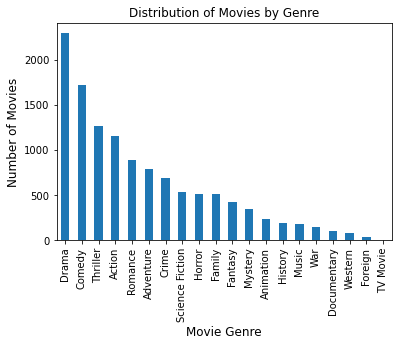

In [26]:
genres_collection_df.plot(x='genre', y='count', kind='bar', legend=False)
plt.title("Distribution of Movies by Genre")
plt.ylabel('Number of Movies', fontsize=12)
plt.xlabel('Movie Genre', fontsize=12)

### How many Genres per Movie?

In [27]:
numGenresPerMovie = genres_collection.sum(axis=1)

In [28]:
numGenresPerMovie = numGenresPerMovie.reset_index()
numGenresPerMovie.columns = ['index', 'NumberOfGenres']

In [29]:
numGenresPerMovie = numGenresPerMovie.drop(['index'], axis=1)

In [30]:
numGenresPerMovie['Count'] = 1

In [31]:
numGenresPerMovie = numGenresPerMovie.groupby(['NumberOfGenres']).sum().reset_index()

Text(0.5, 1.0, 'How many Genres per Movie?')

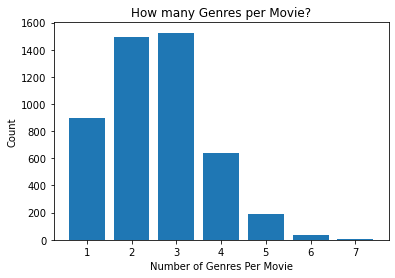

In [32]:
plt.bar(numGenresPerMovie['NumberOfGenres'], numGenresPerMovie['Count'])
plt.xlabel("Number of Genres Per Movie")
plt.ylabel("Count")
plt.title("How many Genres per Movie?")

### How long are movie plot summaries?

Text(0.5, 1.0, 'How long are movie plot overviews?')

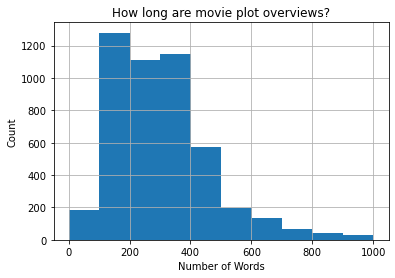

In [33]:
numWords = df['overview'].str.len()
numWords.hist()
plt.xlabel("Number of Words")
plt.ylabel("Count")
plt.title("How long are movie plot overviews?")

In [34]:
numWords.describe()

count    4772.000000
mean      304.993294
std       162.170783
min         1.000000
25%       177.750000
50%       283.000000
75%       392.000000
max      1000.000000
Name: overview, dtype: float64

### What words occur most frequently in plot summary?

In [35]:
from wordcloud import WordCloud, STOPWORDS

In [36]:
wordcloud_txt = df['overview'].str.lower()
wordcloud_txt = ' '.join(wordcloud_txt)

In [37]:
wordcloud = WordCloud(
            background_color ='white', 
            stopwords = set(STOPWORDS)).generate(wordcloud_txt) 

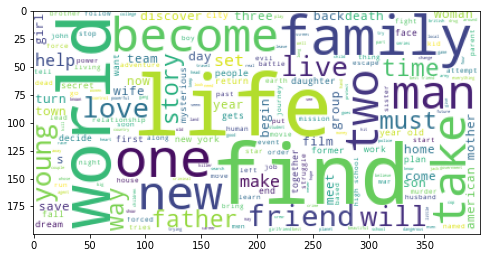

In [38]:
plt.figure(figsize=(8,5))
plt.imshow(wordcloud)
plt.show()

### Text preprocessing - Overview (Plot Summary)

In [40]:
stemmer = stem.SnowballStemmer('english')
stopwords = set(stopwords.words('english'))

In [41]:
def clean_text(text):
    #1. Convert plot summary (overview) to lower case
    text = text.lower() 
    
    #2. Remove punctuation
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    
    #3. Remove stopwords 
    cleaned = [word for word in nopunc.split() if word not in stopwords]
    
    #4. Stem words
    cleaned = ([stemmer.stem(word) for word in cleaned])
    
    #5. Return clean processed text
    return cleaned

In [42]:
tfidfvectorizer = TfidfVectorizer(analyzer=clean_text, stop_words='english', max_features = 10000)

In [43]:
overview_bow = tfidfvectorizer.fit_transform(df['overview'])

In [44]:
overview_bow

<4772x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 125414 stored elements in Compressed Sparse Row format>

In [45]:
YCols = ['Action','Adventure','Animation','Comedy','Crime','Documentary','Drama','Family','Fantasy','Foreign',
        'History','Horror','Music','Mystery','Romance','Science Fiction','TV Movie','Thriller','War','Western']

In [46]:
X_train, X_test, y_train, y_test = train_test_split(overview_bow, df[YCols], test_size = 0.20, random_state = 0)

In [49]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report

In [50]:
from sklearn.ensemble import RandomForestClassifier

In [51]:
model = OneVsRestClassifier(RandomForestClassifier(class_weight='balanced'))

In [52]:
model.fit(X_train, y_train)

OneVsRestClassifier(estimator=RandomForestClassifier(class_weight='balanced'))

In [53]:
y_pred=model.predict(X_test)

In [54]:
print(classification_report(y_test, y_pred, target_names=multilabel_binarizer.classes_))

                 precision    recall  f1-score   support

         Action       0.64      0.34      0.44       213
      Adventure       0.59      0.07      0.12       150
      Animation       0.00      0.00      0.00        52
         Comedy       0.67      0.49      0.57       348
          Crime       0.78      0.21      0.33       139
    Documentary       0.00      0.00      0.00        19
          Drama       0.68      0.61      0.64       474
         Family       0.00      0.00      0.00        96
        Fantasy       1.00      0.01      0.02        82
        Foreign       0.00      0.00      0.00         7
        History       0.00      0.00      0.00        41
         Horror       0.86      0.05      0.10       110
          Music       0.00      0.00      0.00        32
        Mystery       0.00      0.00      0.00        75
        Romance       0.77      0.31      0.44       182
Science Fiction       0.83      0.14      0.24       106
       TV Movie       0.00    

C:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [62]:
multilabel_binarizer.inverse_transform(y_pred)[3]

('Comedy', 'Romance')

### Movie Recommendation System based on Plot Overview Similarity Score

##### Using Cosine Similarity

In [63]:
from sklearn.metrics.pairwise import linear_kernel
cosine_sim = linear_kernel(overview_bow, overview_bow)

In [64]:
movieToIndex = pd.Series(df.index, index=df['title'])
#movieToIndex.head(n=20)

In [65]:
# inspired by: https://towardsdatascience.com/building-a-movie-recommender-using-python-277959b07dae
def movie_recommendation_system(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = movieToIndex[title]

    # Get the pairwsie similarity scores of all movies with that movie
    similarityScore = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    similarityScore = sorted(similarityScore, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    similarityScore = similarityScore[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in similarityScore]
    scores = [i[1] for i in similarityScore]
    
    #Create a dataframe to return
    similarMovies = df['title'].iloc[movie_indices]
    out = pd.DataFrame({'Movie': similarMovies, 'Similarity Score': scores})
    
    # Return the top 10 most similar movies and similarity score
    return out

In [66]:
movie_recommendation_system('Men in Black 3')

,Movie,Similarity Score
1409,J. Edgar,0.159865
594,Bad Company,0.157184
2256,The Oogieloves in the Big Balloon Adventure,0.156694
2507,Slow Burn,0.144792
280,Public Enemies,0.123155
735,The Tuxedo,0.122104
2865,Project Almanac,0.119256
540,Hollywood Homicide,0.115035
865,Seven Pounds,0.110338
58,Rush Hour 3,0.108449


### Is there a relationship between Budget and Popularity?

Text(0.5, 1.0, 'Popularity vs Budget')

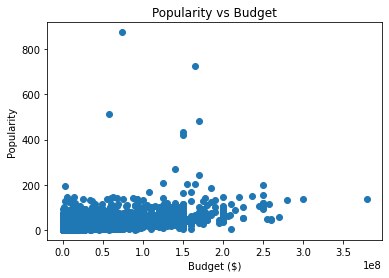

In [61]:
plt.scatter(df['budget'],df['popularity'])
plt.xlabel("Budget ($)")
plt.ylabel("Popularity")
plt.title("Popularity vs Budget")

#### Is there a relationship between Popularity and Rating (Vote Avg)?

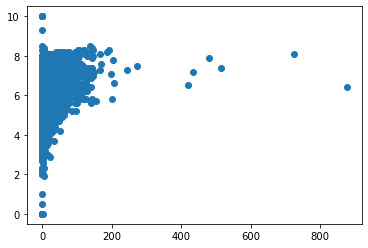

In [62]:
plt.scatter(df['popularity'],df['vote_average'])

### Predictive Model: Likelihood that a movie will have high revenue (before the movie is released)

In [68]:
df['revenue'].quantile(0.75)

93637756.75

In [69]:
df['IsHighRevenue'] = np.where(df['revenue'] >= 93637756.75, 1, 0)

In [70]:
df['IsHighRevenue'].describe()

count    4772.000000
mean        0.250000
std         0.433058
min         0.000000
25%         0.000000
50%         0.000000
75%         0.250000
max         1.000000
Name: IsHighRevenue, dtype: float64

In [71]:
X_train, X_test, y_train, y_test = train_test_split(overview_bow, df['IsHighRevenue'], test_size = 0.30, random_state = 0)

In [72]:
print(X_train.shape)
print(X_test.shape)

(3340, 10000)
(1432, 10000)


In [73]:
print(y_train.sum())
print(y_test.sum())

834
359


In [75]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=100, max_features="sqrt", class_weight='balanced', min_samples_leaf=5)
classifier.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_features='sqrt',
                       min_samples_leaf=5)

In [76]:
#Evaluate the model on the training data set
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
pred = classifier.predict(X_train)
print(classification_report(y_train ,pred ))
print('Confusion Matrix: \n',confusion_matrix(y_train,pred))
print()
print('Accuracy: ', accuracy_score(y_train,pred))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94      2506
           1       0.80      0.86      0.83       834

    accuracy                           0.91      3340
   macro avg       0.88      0.90      0.89      3340
weighted avg       0.92      0.91      0.91      3340

Confusion Matrix: 
 [[2332  174]
 [ 116  718]]

Accuracy:  0.9131736526946108


In [77]:
#Evaluate the model on the test data set
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
pred = classifier.predict(X_test)
print(classification_report(y_test ,pred ))
print('Confusion Matrix: \n', confusion_matrix(y_test,pred))
print()
print('Accuracy: ', accuracy_score(y_test,pred))

              precision    recall  f1-score   support

           0       0.80      0.85      0.82      1073
           1       0.44      0.34      0.38       359

    accuracy                           0.73      1432
   macro avg       0.62      0.60      0.60      1432
weighted avg       0.71      0.73      0.71      1432

Confusion Matrix: 
 [[916 157]
 [236 123]]

Accuracy:  0.7255586592178771


### Which words are most important?

In [114]:
importances = classifier.feature_importances_
indices = np.argsort(importances)[::-1]

In [115]:
feature_names = tfidfvectorizer.get_feature_names()

In [116]:
imp = pd.DataFrame(columns=['Word', 'Variable Importance'], index=range(10))

In [117]:
for i in range(10):
    imp.loc[i]['Word'] = feature_names[indices[i]]
    imp.loc[i]['Variable Importance'] = importances[indices[i]]

In [118]:
imp = imp[imp['Word']!='–']

In [119]:
imp

,Word,Variable Importance
0,world,0.013482
2,name,0.0109639
3,mother,0.00864634
4,life,0.00701547
5,earth,0.00656843
6,friend,0.00617121
7,face,0.00608967
8,must,0.00595519
9,find,0.00586834
